In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn import tree

#### Load Data

In [3]:
AAPL_data = pd.read_csv('Data/AAPL.csv')

#### Extract train and test data

We will extract the last month's data as the test data and the rest as the train data

We take the date from 2022-02-24 to 2023-01-31 as the train data and make the test data from 2023-02-01 to 2023-02-23

In [4]:
train_df = AAPL_data[(AAPL_data['Date']>'2022-02-23') & (AAPL_data['Date']<='2023-01-31')]
test_df = AAPL_data[(AAPL_data['Date']>'2023-01-31')]

In [5]:
X_train = train_df.drop(['Date','Open'],axis=1)
y_train = np.array(train_df[['Open']]).reshape(-1)
X_test = test_df.drop(['Date','Open'],axis=1)
y_test = np.array(test_df[['Open']]).reshape(-1)

#### Use Pipeline by having PCA and DecisionTree

In [6]:
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()
pipe = Pipeline(steps=[ ('pca', pca),
                        ('dec_tree', dec_tree)])

#pca no of components
n_components = list(range(1,X_train.shape[1]+1,1))

# decision tree parameters
criterion = ['gini', 'entropy']
min_samples_leaf = [5, 10, 20, 50, 100]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
max_features =  ['auto', 'sqrt', 'log2']

parameters = dict(pca__n_components=n_components,
                  dec_tree__criterion=criterion,
                  dec_tree__min_samples_leaf=min_samples_leaf,
                  dec_tree__min_samples_split=min_samples_split,
                  dec_tree__max_features=max_features)

In [15]:
clf_GS = GridSearchCV(pipe, parameters,return_train_score=True)
clf_GS.fit(X_train, y_train.astype(int))

/Users/jiaweima/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_features': ['auto', 'sqrt', 'log2'],
                         'dec_tree__min_samples_leaf': [5, 10, 20, 50, 100],
                         'dec_tree__min_samples_split': [2, 4, 6, 8, 10, 12, 14,
                                                         16, 18, 20],
                         'pca__n_components': [1, 2, 3, 4, 5]},
             return_train_score=True)

In [16]:
clf_GS.best_params_

{'dec_tree__criterion': 'gini',
 'dec_tree__max_features': 'auto',
 'dec_tree__min_samples_leaf': 5,
 'dec_tree__min_samples_split': 4,
 'pca__n_components': 4}

#### Train and Validation Errors Plot

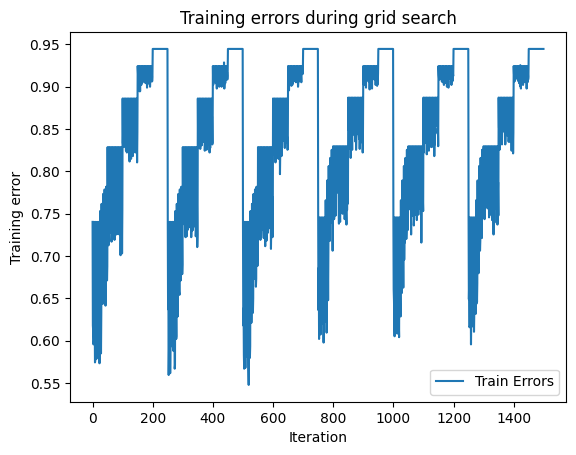

In [17]:
train_errors = 1 - clf_GS.cv_results_['mean_train_score']
plt.plot(train_errors, label='Train Errors')
plt.xlabel('Iteration')
plt.ylabel('Training error')
plt.title('Training errors during grid search')
plt.legend()
plt.show()

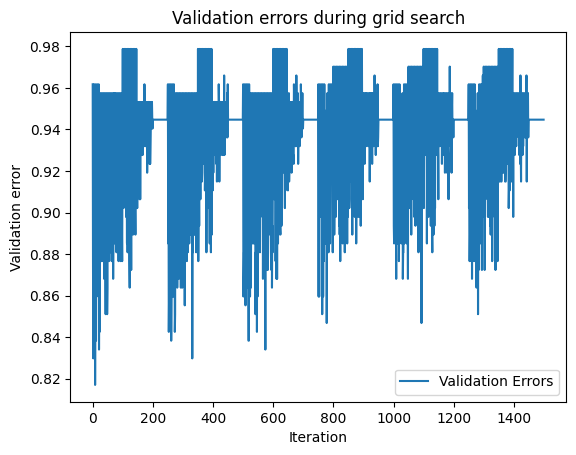

In [18]:
test_errors = 1-clf_GS.cv_results_['mean_test_score']
plt.plot(test_errors,label='Validation Errors')
plt.xlabel('Iteration')
plt.ylabel('Validation error')
plt.title('Validation errors during grid search')
plt.legend()
plt.show()

#### Evaluate Model

In [9]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#### Base Model

In [10]:
base_model = DecisionTreeClassifier()
base_model.fit(X_train, y_train.astype(int))
evaluate(base_model, X_test,y_test)

Model Performance
Average Error: 1.2594 degrees.
Accuracy = 99.16%.


99.16312668773462

#### Best Model

In [11]:
model = clf_GS.best_estimator_
evaluate(model, X_test, y_test)

Model Performance
Average Error: 1.4194 degrees.
Accuracy = 99.06%.


99.05718030008845

#### Plot Predictions

In [12]:
y_pred = model.predict(X_test)
predict_df = pd.concat([pd.DataFrame(y_pred, columns=['Predict']), pd.DataFrame(y_test, columns=['Actual'])],axis=1)
predict_df.set_index(np.array(AAPL_data[(AAPL_data['Date']>'2023-01-31')].Date),inplace=True)

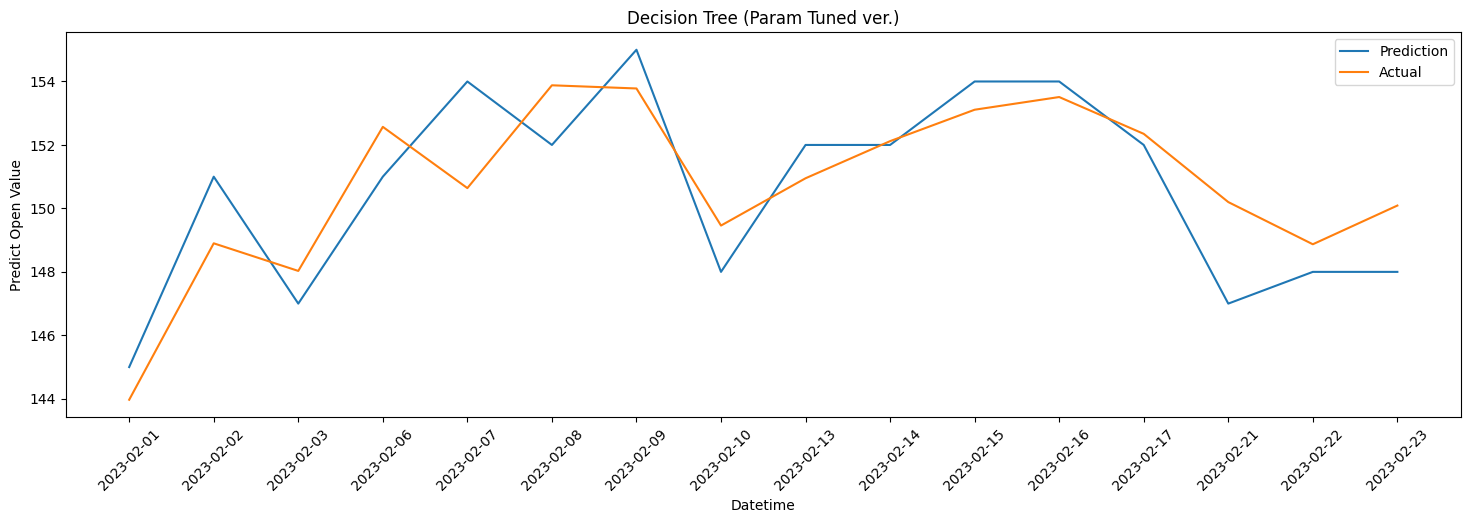

In [13]:
plt.figure(figsize=(18,5))
plt.plot(predict_df['Predict'], label='Prediction')
plt.xticks(rotation=45)
plt.plot(predict_df['Actual'], label='Actual')
plt.title('Decision Tree (Param Tuned ver.)')
plt.xlabel('Datetime')
plt.ylabel('Predict Open Value')
plt.legend()
plt.show()

In [14]:
y_pred = base_model.predict(X_test)
predict_df = pd.concat([pd.DataFrame(y_pred, columns=['Predict']), pd.DataFrame(y_test, columns=['Actual'])],axis=1)
predict_df.set_index(np.array(AAPL_data[(AAPL_data['Date']>'2023-01-31')].Date),inplace=True)

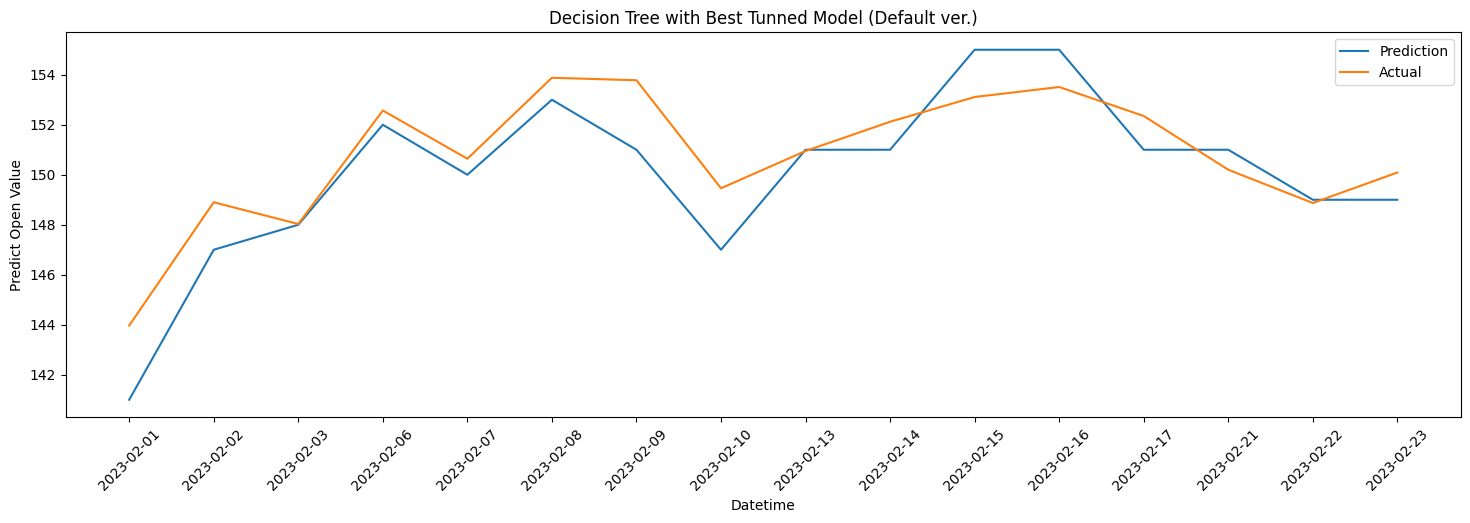

In [15]:
plt.figure(figsize=(18,5))
plt.plot(predict_df['Predict'], label='Prediction')
plt.xticks(rotation=45)
plt.plot(predict_df['Actual'], label='Actual')
plt.title('Decision Tree with Best Tunned Model (Default ver.)')
plt.xlabel('Datetime')
plt.ylabel('Predict Open Value')
plt.legend()
plt.show()